In [136]:
import pandas as pd, numpy as np
from glob import glob
import os
from multiprocessing import Pool
from tqdm import tqdm

# Plot the coverages

In [145]:
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [146]:
# Add strand info
L1_bins=pd.read_csv('L1_bins.tsv',sep='\t',names=['chr','start','end','L1_id','-','strand'])
L1_bins['TE_id']=L1_bins['L1_id'].str.extract('(chr.*_[0-9]+)_bin[-]*[0-9]+')
L1 = L1_bins.groupby(['TE_id'])['strand'].first().reset_index()

L1_bins['bin']=L1_bins['L1_id'].str.extract(r'.*_bin([-0-9]+)').astype(int)
L1 = L1_bins[L1_bins['bin']==0]
L1['TSS'] = L1['start']
L1.loc[L1['strand']=='-','TSS']=L1.loc[L1['strand']=='-','end']

# Annotate which elements are within a gene body
gencode = pd.read_csv('/cndd2/jchien/iGenome/gencodev37/gencode.v37.annotation.intragenic_proteincoding_linRNA.bed.gz',sep='\t',
                      names=['chr','start','end','gene_id','strand','-','gene_name','gene_type'],
                     index_col='gene_id')
for i in L1.index:
  L1u=L1.loc[i]
  genes=gencode[(gencode['chr']==L1u['chr'])&(gencode['start']<=L1u['TSS'])&(gencode['end']>=L1u['TSS'])&(gencode['strand']==L1u['strand'])]
  L1.loc[i,'ngenes_samestrand']=genes.shape[0]
  genes=gencode[(gencode['chr']==L1u['chr'])&(gencode['start']<=L1u['TSS'])&(gencode['end']>=L1u['TSS'])&(gencode['strand']!=L1u['strand'])]
  L1.loc[i,'ngenes_oppstrand']=genes.shape[0]

In [261]:
!ls L1_bins.Sample_1134_GABA* -ltr

-rw-r--r-- 1 emukamel domain users 1821542 Nov  1 22:54 L1_bins.Sample_1134_GABA.sense.coverage.bed
-rw-r--r-- 1 emukamel domain users 1816678 Nov  1 22:54 L1_bins.Sample_1134_GABA.antisense.coverage.bed
-rw-r--r-- 1 emukamel domain users 1821542 Nov  2 09:48 L1_bins.Sample_1134_GABA.q30.sense.coverage.bed
-rw-r--r-- 1 emukamel domain users 1816678 Nov  2 09:48 L1_bins.Sample_1134_GABA.q30.antisense.coverage.bed


In [258]:
samples=glob('L1_bins.Sample*[GLU|GABA].q30.sense.coverage.bed')

In [233]:
def my_load(sample):
  df1=pd.read_csv(sample,sep='\t',names=['chr','start','end','id','tmp1','tmp2','coverage'])
  df1['strand']='antisense'
  df2 = pd.read_csv(sample.replace('.sense.coverage','.antisense.coverage'),sep='\t',names=['chr','start','end','id','tmp1','tmp2','coverage'])
  df2['strand']='sense'
  df=df1.append(df2)
  
  
  df=df.groupby(['chr','start','end','strand','id'])['coverage'].sum().reset_index()

  df['sample']=sample.split('.')[1].replace('Sample_','')
  df['TE_id']=df['id'].str.extract('(chr.*_[0-9]+)_bin[-]*[0-9]+')
  df['bin']=df['id'].str.extract('chr.*_[0-9]+_bin([-]*[0-9]+)')
  
  samplename=re.match(r'L1_bins\.(Sample_.*)\.sense\.coverage\.bed',sample).group(1)
  libsize=pd.read_csv(f'{samplename}.libsize.txt',header=None)
  df['libsize']=libsize.values[0][0]
  
  return df

with Pool() as p:
  dfs=list(tqdm(p.imap(my_load, samples),total=len(samples)))

100%|██████████| 116/116 [00:08<00:00, 13.31it/s]


In [234]:
df=pd.concat(dfs)
df=df.dropna()
df['bin']=df['bin'].astype(int)

df['CPM']=1e6*df['coverage']/df['libsize']

df=df.merge(L1[['TE_id','ngenes_samestrand','ngenes_oppstrand','TSS']],on='TE_id',how='left')
df['Position rel. L1 TSS (kb)']=df['bin']/1000

In [235]:
df['gene_overlap']=pd.Categorical(['Intergenic']*df.shape[0],categories=['Intergenic','Intron','Antisense','Intron+Antisense'],ordered=True)
df.loc[df['ngenes_samestrand']>0,'gene_overlap']='Intron'
df.loc[df['ngenes_oppstrand']>0,'gene_overlap']='Antisense'
df.loc[(df['ngenes_oppstrand']>0)&(df['ngenes_samestrand']>0),'gene_overlap']='Intron+Antisense'

In [236]:
assert (df.groupby(['id','strand','sample'])['CPM'].count()==1).all()

In [237]:
# Add metadata about samples
meta=pd.read_csv('../PsychENCODE and SCZ sample metadata - PEC_RNAmeta.csv')
meta['sample']=meta['Sample ID'].str.replace('/','-')+'_'+meta['Cell Type']
meta['sample']=meta['sample'].str.replace('174052-1241','1241').str.upper()
assert set(meta['sample'])==set(df['sample'])

meta['sex']=meta['sex'].str.lower()
meta['AGEDAYS'].fillna(0,inplace=True)
meta['age'] = meta['AGEYEARS']+meta['AGEDAYS']/365
meta['age_group'] = pd.cut(meta['age'],bins=[0,2,5,10,20,40,70,80],
                           labels=['Infancy (0-2 yo)','Early childhood (2-5)','Late childhood (5-10)','Adolescence (10-20)','Adulthood (20-40)','Middle age (40-70)','Late adulthood (70-80)'],
                          ordered=True)

# df.merge(meta,on='sample')
df=df.merge(meta[['sample','age_group','sex']],on='sample')

In [238]:
df['celltype']=df['sample'].str.extract('_(GLU|GABA)')

In [239]:
df_epochs=df.sort_values(['age_group']).groupby(['TE_id','Position rel. L1 TSS (kb)','age_group','celltype','sex','strand','gene_overlap'])[['CPM']].mean().dropna()
df_epochs_mean=df_epochs.groupby(['celltype','age_group','sex','strand','gene_overlap','Position rel. L1 TSS (kb)'])[['CPM']].mean().dropna()

In [240]:
# Normalize
libsize=df_epochs_mean.unstack('Position rel. L1 TSS (kb)').iloc[:,:40].mean(axis=1)
df_epochs_mean['mRNA coverage (normalized by flank)']=df_epochs_mean['CPM'].div(libsize,axis=0)
# df_epochs_mean=df_epochs_mean.rename(columns={'coverage':'mRNA coverage (normalized by flank)'})

In [241]:
# df_epochs_mean[df_epochs_mean.sort_index().index.duplicated(keep=False)]
df_epochs_mean.sort_index().index.duplicated(keep=False).any()

False

In [256]:
df_epochs_mean

CPM  \
celltype age_group              sex    strand    gene_overlap     Position rel. L1 TSS (kb)             
GABA     Infancy (0-2 yo)       female antisense Intergenic       -50.0                      0.064285   
                                                                  -49.0                      0.061569   
                                                                  -48.0                      0.066527   
                                                                  -47.0                      0.058939   
                                                                  -46.0                      0.063164   
...                                                                                               ...   
GLU      Late adulthood (70-80) male   sense     Intron+Antisense  45.0                      0.038060   
                                                                   46.0                      0.064506   
                                                                   47.0                      0.047280   
                                                                   48.0                      0.102685   
                                                                   49.0                      0.039950   

                                                                                             mRNA coverage (normalized by flank)  
celltype age_group              sex    strand    gene_overlap     Position rel. L1 TSS (kb)                                       
GABA     Infancy (0-2 yo)       female antisense Intergenic       -50.0                                                 0.937102  
                                                                  -49.0                                                 0.897506  
                                                                  -48.0                                                 0.969785  
                                                                  -47.0                                                 0.859168  
                                                                  -46.0                                                 0.920761  
...                                                                                                                          ...  
GLU      Late adulthood (70-80) male   sense     Intron+Antisense  45.0                                                 0.267629  
                                                                   46.0                                                 0.453589  
                                                                   47.0                                                 0.332464  
                                                                   48.0                                                 0.722053  
                                                                   49.0                                                 0.280920  

[20800 rows x 2 columns]

CPU times: user 3.1 s, sys: 537 ms, total: 3.64 s
Wall time: 3.31 s


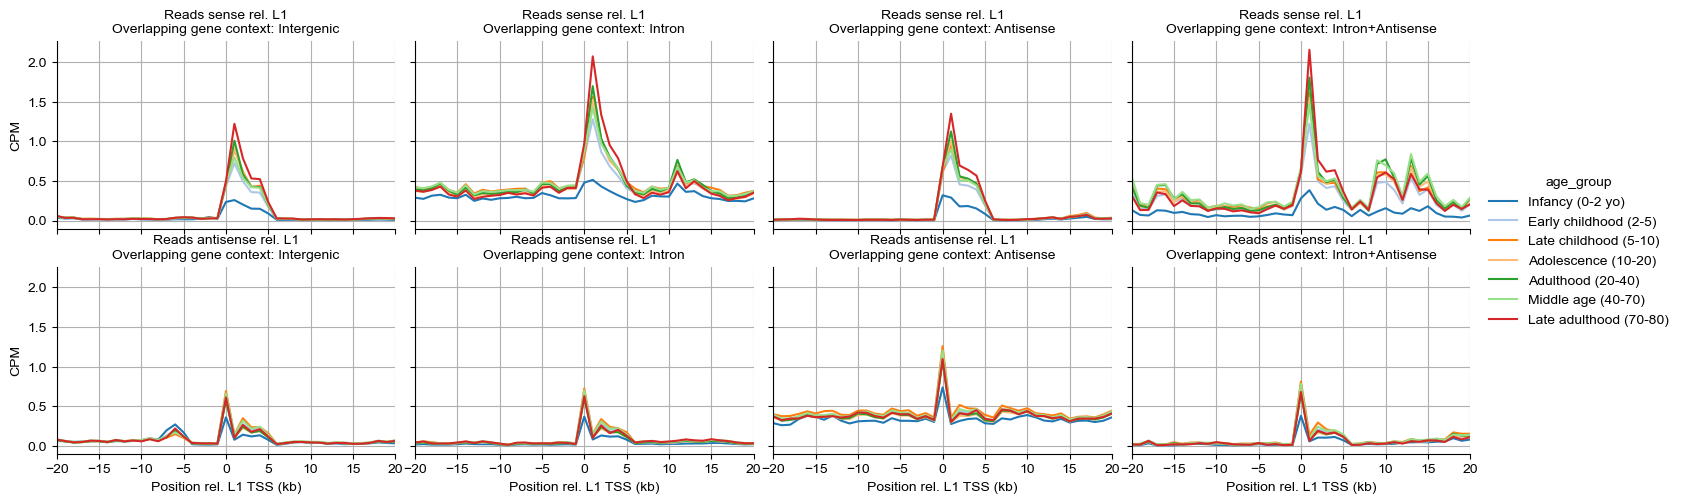

In [262]:
%%time
g=sns.relplot(df_epochs_mean.loc['GABA'],
              kind='line',
            x='Position rel. L1 TSS (kb)',
              y='CPM',
#               y='mRNA coverage (normalized by flank)',
            hue='age_group',
              col='gene_overlap',
              row='strand',row_order=['sense','antisense'],
            errorbar=None,
            estimator='median',
            height=2.5,aspect=1.5,
              palette='tab20'
           )
g.set_titles(template='Reads {row_name} rel. L1\nOverlapping gene context: {col_name}')
for ax in g.axes.flatten():
  ax.grid()
  ax.set_xlim([-20,20])

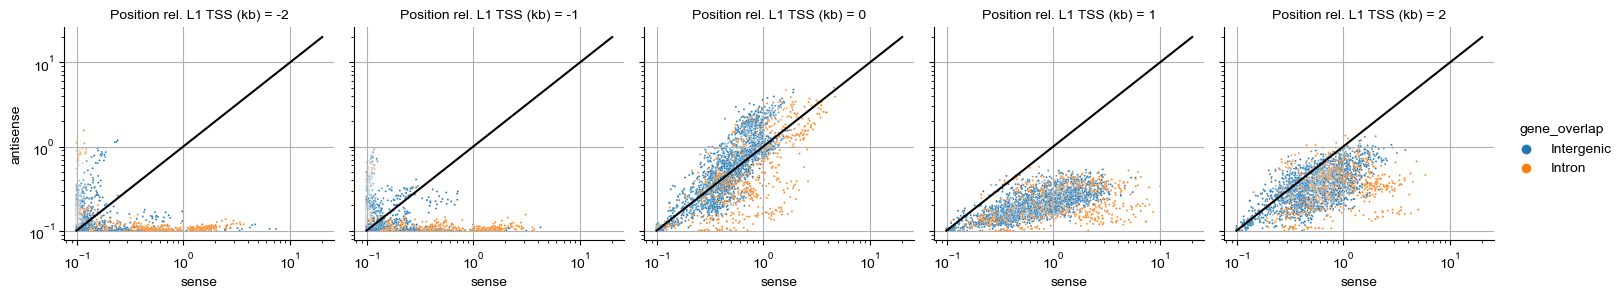

In [253]:
g=sns.relplot(df_epochs.dropna().unstack('strand')['CPM']+0.1,
            kind='scatter',
            x='sense',y='antisense',
              hue='gene_overlap',hue_order=['Intergenic','Intron'],
            col='Position rel. L1 TSS (kb)',col_order=[-2,-1,0,1,2],
              height=3,aspect=1,
            s=2
             )

for ax in g.axes.flatten():
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.plot([.1,20],[.1,20],'k')
  ax.grid()

In [232]:
df_show=df.groupby(['strand','TE_id','Position rel. L1 TSS (kb)'])['CPM'].mean().unstack(['strand','Position rel. L1 TSS (kb)'])
df_show=df_show.iloc[df_show.mean(axis=1).argsort()[::-1]]

In [122]:
df

,chr,start,end,id,coverage,strand,sample,TE_id,bin,libsize,CPM,ngenes_samestrand,ngenes_oppstrand,TSS,Position rel. L1 TSS (kb),gene_overlap,age_group,sex,celltype
0,chr1,34522105,34523105,chr1_34566056_bin49000,0,sense,5401_GABA,chr1_34566056,49000,328412792,0.000000,0.0,0.0,34572105,49.0,Intergenic,Adolescence (10-20),female,GABA
1,chr1,34523105,34524105,chr1_34566056_bin48000,2,sense,5401_GABA,chr1_34566056,48000,328412792,0.006090,0.0,0.0,34572105,48.0,Intergenic,Adolescence (10-20),female,GABA
2,chr1,34524105,34525105,chr1_34566056_bin47000,2,sense,5401_GABA,chr1_34566056,47000,328412792,0.006090,0.0,0.0,34572105,47.0,Intergenic,Adolescence (10-20),female,GABA
3,chr1,34525105,34526105,chr1_34566056_bin46000,0,sense,5401_GABA,chr1_34566056,46000,328412792,0.000000,0.0,0.0,34572105,46.0,Intergenic,Adolescence (10-20),female,GABA
4,chr1,34526105,34527105,chr1_34566056_bin45000,0,sense,5401_GABA,chr1_34566056,45000,328412792,0.000000,0.0,0.0,34572105,45.0,Intergenic,Adolescence (10-20),female,GABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897595,chrX,155567048,155568048,chrX_155516017_bin-46000,47,antisense,5643_GABA,chrX_155516017,-46000,352452776,0.133351,1.0,1.0,155522048,-46.0,Intron+Antisense,Adolescence (10-20),male,GABA
3897596,chrX,155568048,155569048,chrX_155516017_bin-47000,48,antisense,5643_GABA,chrX_155516017,-47000,352452776,0.136188,1.0,1.0,155522048,-47.0,Intron+Antisense,Adolescence (10-20),male,GABA
3897597,chrX,155569048,155570048,chrX_155516017_bin-48000,90,antisense,5643_GABA,chrX_155516017,-48000,352452776,0.255353,1.0,1.0,155522048,-48.0,Intron+Antisense,Adolescence (10-20),male,GABA
3897598,chrX,155570048,155571048,chrX_155516017_bin-49000,104,antisense,5643_GABA,chrX_155516017,-49000,352452776,0.295075,1.0,1.0,155522048,-49.0,Intron+Antisense,Adolescence (10-20),male,GABA


In [176]:
sample='L1_bins.Sample_4321_GLU.sense.coverage.bed'
df1=pd.read_csv(sample,sep='\t',names=['chr','start','end','id','tmp1','tmp2','coverage'])
df1['strand']='sense'
df2 = pd.read_csv(sample.replace('.sense.coverage','.antisense.coverage'),sep='\t',names=['chr','start','end','id','tmp1','tmp2','coverage'])
df2['strand']='antisense'
df=df1.append(df2)
df['bin']=df['id'].str.extract('.*_bin([-0-9]+)').astype(int)
df['TE_id']=df['id'].str.extract('(.*)_bin[-0-9]+')

In [180]:
df[(df['TE_id']=='chr11_85324759')].sort_values(['id','strand'])

,chr,start,end,id,tmp1,tmp2,coverage,strand,bin,TE_id
11049,chr11,85323759,85324759,chr11_85324759_bin-1000,-,+,0,antisense,-1000,chr11_85324759
27849,chr11,85323759,85324759,chr11_85324759_bin-1000,-,+,2,antisense,-1000,chr11_85324759
11049,chr11,85323759,85324759,chr11_85324759_bin-1000,-,+,123,sense,-1000,chr11_85324759
27849,chr11,85323759,85324759,chr11_85324759_bin-1000,-,+,72,sense,-1000,chr11_85324759
11040,chr11,85314759,85315759,chr11_85324759_bin-10000,-,+,0,antisense,-10000,chr11_85324759
...,...,...,...,...,...,...,...,...,...,...
27858,chr11,85332759,85333759,chr11_85324759_bin8000,-,+,81,sense,8000,chr11_85324759
11059,chr11,85333759,85334759,chr11_85324759_bin9000,-,+,2,antisense,9000,chr11_85324759
27859,chr11,85333759,85334759,chr11_85324759_bin9000,-,+,2,antisense,9000,chr11_85324759
11059,chr11,85333759,85334759,chr11_85324759_bin9000,-,+,140,sense,9000,chr11_85324759


<Axes: xlabel='bin', ylabel='coverage'>

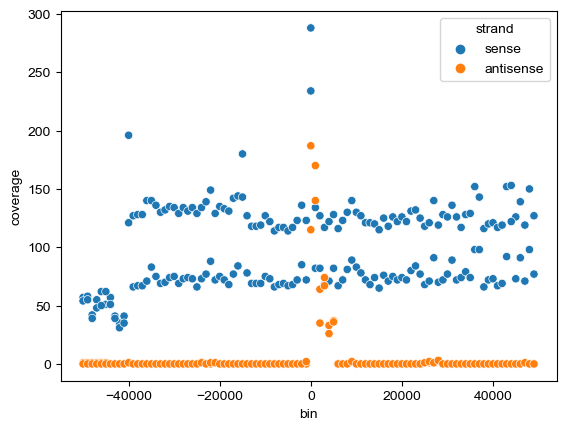

In [177]:
sns.scatterplot(df[(df['TE_id']=='chr11_85324759')],x='bin',y='coverage',hue='strand')

In [123]:
# chr11_85324759
df_show=df[(df['TE_id']=='chr11_85324759')&(df['sample']=='4321_GLU')].groupby(['strand','celltype','Position rel. L1 TSS (kb)'])['coverage'].sum().rename('CPM')
df_show

strand     celltype  Position rel. L1 TSS (kb)
antisense  GLU       -50.0                         55
                     -49.0                         56
                     -48.0                         40
                     -47.0                         49
                     -46.0                         51
                                                 ... 
sense      GLU        45.0                        126
                      46.0                        139
                      47.0                        120
                      48.0                        150
                      49.0                        127
Name: CPM, Length: 200, dtype: int64

73

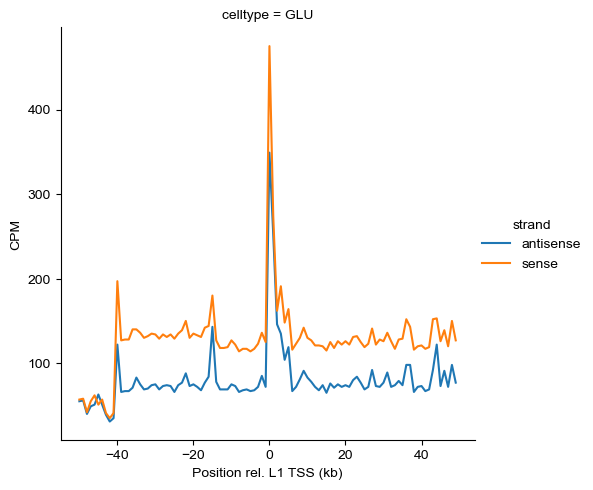

In [124]:
# sns.lineplot(df_show.iloc[24].rename('CPM').reset_index(),
sns.relplot(df_show.reset_index(),kind='line',
             hue='strand',
            col='celltype',
             x='Position rel. L1 TSS (kb)',y='CPM')
# df_show.iloc[0].rename('CPM')
df_show.iloc[24]

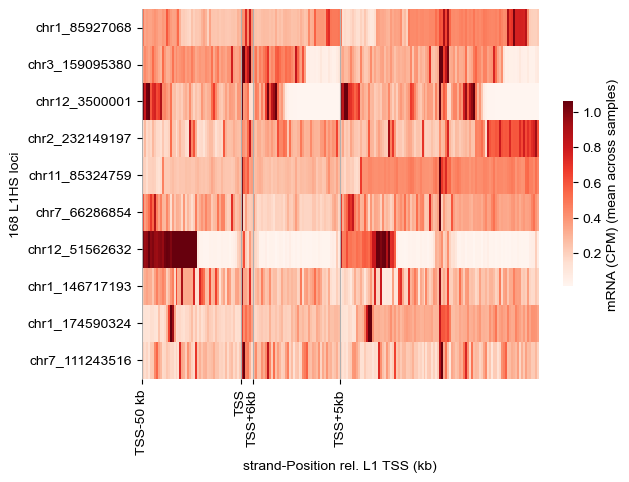

In [91]:
ax=sns.heatmap(df_show.iloc[20:30],
#                yticklabels=False,
               robust=True,cmap='Reds',
               cbar_kws={'shrink':.5,'label':'mRNA (CPM) (mean across samples)'}
              )
ax.set_ylabel(f'{df_show.shape[0]} L1HS loci')
ax.set_xticks([0,50,56,100],labels=['TSS-50 kb','TSS','TSS+6kb','TSS+5kb'])
ax.grid(axis='x')
# ax.get_figure().savefig('Plots/MeanRNA_CPM_heatmap.pdf')

In [44]:
df_wide=df_epochs_mean.unstack('Position rel. L1 TSS (kb)')

In [47]:
df.groupby(['TE_id','strand','Position rel. L1 TSS (kb)'])['CPM']

,chr,start,end,id,coverage,strand,sample,TE_id,bin,libsize,CPM,ngenes_samestrand,ngenes_oppstrand,TSS,Position rel. L1 TSS (kb),gene_overlap,age_group,sex
0,chr1,34522105,34523105,chr1_34566056_bin49000,0,sense,5401_GABA,chr1_34566056,49000,328412792,0.000000,0.0,0.0,34572105,49.0,Intergenic,Adolescence (10-20),female
1,chr1,34523105,34524105,chr1_34566056_bin48000,2,sense,5401_GABA,chr1_34566056,48000,328412792,0.006090,0.0,0.0,34572105,48.0,Intergenic,Adolescence (10-20),female
2,chr1,34524105,34525105,chr1_34566056_bin47000,2,sense,5401_GABA,chr1_34566056,47000,328412792,0.006090,0.0,0.0,34572105,47.0,Intergenic,Adolescence (10-20),female
3,chr1,34525105,34526105,chr1_34566056_bin46000,0,sense,5401_GABA,chr1_34566056,46000,328412792,0.000000,0.0,0.0,34572105,46.0,Intergenic,Adolescence (10-20),female
4,chr1,34526105,34527105,chr1_34566056_bin45000,0,sense,5401_GABA,chr1_34566056,45000,328412792,0.000000,0.0,0.0,34572105,45.0,Intergenic,Adolescence (10-20),female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897595,chrX,155567048,155568048,chrX_155516017_bin-46000,47,antisense,5643_GABA,chrX_155516017,-46000,352452776,0.133351,1.0,1.0,155522048,-46.0,Intron+Antisense,Adolescence (10-20),male
3897596,chrX,155568048,155569048,chrX_155516017_bin-47000,48,antisense,5643_GABA,chrX_155516017,-47000,352452776,0.136188,1.0,1.0,155522048,-47.0,Intron+Antisense,Adolescence (10-20),male
3897597,chrX,155569048,155570048,chrX_155516017_bin-48000,90,antisense,5643_GABA,chrX_155516017,-48000,352452776,0.255353,1.0,1.0,155522048,-48.0,Intron+Antisense,Adolescence (10-20),male
3897598,chrX,155570048,155571048,chrX_155516017_bin-49000,104,antisense,5643_GABA,chrX_155516017,-49000,352452776,0.295075,1.0,1.0,155522048,-49.0,Intron+Antisense,Adolescence (10-20),male


In [45]:
# df_wide_mean=df_wide.groupby('TE_id',axis=0).mean()
# df_wide_mean=df_wide_mean.iloc[df_wide_mean.mean(axis=1).argsort()[::-1]]
df_wide

CPM            \
Position rel. L1 TSS (kb)                                    -50.0     -49.0   
age_group              sex    strand    gene_overlap                           
Infancy (0-2 yo)       female antisense Intergenic        0.049830  0.049734   
                                        Intron            0.166669  0.123237   
                                        Antisense         0.133643  0.139334   
                                        Intron+Antisense  0.031597  0.050268   
                              sense     Intergenic        0.060431  0.060017   
...                                                            ...       ...   
Late adulthood (70-80) male   antisense Intron+Antisense  0.085439  0.145081   
                              sense     Intergenic        0.059417  0.055040   
                                        Intron            0.262010  0.209844   
                                        Antisense         0.219909  0.316044   
                                        Intron+Antisense  0.077039  0.164374   

                                                                              \
Position rel. L1 TSS (kb)                                    -48.0     -47.0   
age_group              sex    strand    gene_overlap                           
Infancy (0-2 yo)       female antisense Intergenic        0.054620  0.058811   
                                        Intron            0.158272  0.139864   
                                        Antisense         0.162318  0.156434   
                                        Intron+Antisense  0.037970  0.029130   
                              sense     Intergenic        0.062683  0.067043   
...                                                            ...       ...   
Late adulthood (70-80) male   antisense Intron+Antisense  0.127298  0.091677   
                              sense     Intergenic        0.061330  0.062416   
                                        Intron            0.231567  0.205573   
                                        Antisense         0.454840  0.300091   
                                        Intron+Antisense  0.119643  0.088535   

                                                                              \
Position rel. L1 TSS (kb)                                    -46.0     -45.0   
age_group              sex    strand    gene_overlap                           
Infancy (0-2 yo)       female antisense Intergenic        0.044028  0.042587   
                                        Intron            0.147829  0.140755   
                                        Antisense         0.147584  0.167404   
                                        Intron+Antisense  0.026196  0.035131   
                              sense     Intergenic        0.054602  0.053265   
...                                                            ...       ...   
Late adulthood (70-80) male   antisense Intron+Antisense  0.082415  0.107364   
                              sense     Intergenic        0.049337  0.058503   
                                        Intron            0.217322  0.196021   
                                        Antisense         0.285144  0.297761   
                                        Intron+Antisense  0.087576  0.120142   

                                                                              \
Position rel. L1 TSS (kb)                                    -44.0     -43.0   
age_group              sex    strand    gene_overlap                           
Infancy (0-2 yo)       female antisense Intergenic        0.046621  0.045556   
                                        Intron            0.160708  0.189758   
                                        Antisense         0.162854  0.186070   
                                        Intron+Antisense  0.020576  0.019871   
                              sense     Intergenic        0.057291  0.055242   
...                                                         

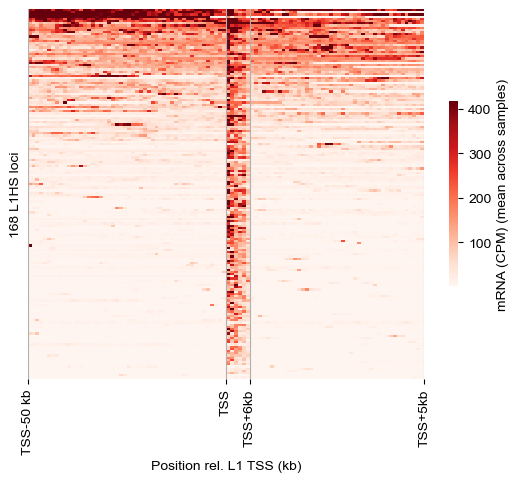

In [172]:
ax=sns.heatmap(df_wide_mean,yticklabels=False,robust=True,cmap='Reds',
               cbar_kws={'shrink':.5,'label':'mRNA (CPM) (mean across samples)'}
              )
ax.set_ylabel(f'{df_wide_mean.shape[0]} L1HS loci')
ax.set_xticks([0,50,56,100],labels=['TSS-50 kb','TSS','TSS+6kb','TSS+5kb'])
ax.grid(axis='x')
ax.get_figure().savefig('Plots/MeanRNA_CPM_heatmap.pdf')

In [168]:
!mkdir Plots